# ИЗУЧЕНИЕ ВРАЩЕНИЯ ГАЛАКТИКИ ПО ЛУЧЕВЫМ СКОРОСТЯМ И СОБСТВЕННЫМ ДВИЖЕНИЯМ ЗВЕЗД
##### выполнил Кузьмин Иван 
4 курс 432

18.10.2022 

Работа была выполнена основываясь на методическом пособии: http://www.sai.msu.ru/ao/speccourses/posobiya/MW-rotation.pdf


In [2]:
import numpy as np
import astropy.io
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.table import QTable
from astropy.coordinates import SkyCoord
from mpl_toolkits import mplot3d
from dataclasses import dataclass
from scipy.optimize import minimize
R0=8.2

### Загрузим данные

In [3]:
#Размерности столбцов в таблице
# deg deg kpc kpc mas/year mas/year  mas/year  mas/year  mas/year  m m  0

#Загрузим таблицу
data_all = QTable.read("Cepheids_L_R_GDR2.dat", format='ascii')
data_all

RAJ2000,DEJ2000,D_Laz,e_DLaz,pmRA,e_pmRA,pmDE,e_pmDE,pm_corr,RV,e_RV,No2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
292.33901036962,-7.04412430546,0.6273,0.065,1.983,0.186,-12.823,0.158,-0.0774,1.1,2.0,1
286.16423452505,1.30614363512,2.0851,0.2388,0.285,0.075,-2.512,0.072,0.1245,10.5,1.0,2
287.05728929396,1.298632119,1.0302,0.1153,-0.272,0.085,-4.555,0.079,0.0833,3.7,0.1,3
284.56144610824,17.36087370956,0.475,0.0485,-1.068,0.158,-9.693,0.167,-0.3897,-15.8,0.1,4
287.31662684606,10.55246598531,0.9112,0.0928,0.261,0.092,-5.24,0.087,0.1094,-5.2,0.1,5
288.19713804039,3.55739850785,1.5115,0.1623,-1.814,0.104,-4.508,0.098,-0.0232,12.8,0.1,6
285.3322079706,0.14700336756,2.087,0.2173,-0.095,0.098,-1.335,0.095,0.1909,11.5,1.0,7
284.35110673574,-0.73023867567,1.9481,0.1791,-1.711,0.09,-2.15,0.073,-0.2002,24.9,7.0,8
287.08654408297,-7.4377683277,1.2465,0.1341,-0.609,0.08,-5.38,0.073,0.0505,6.8,1.0,9


Очистим данные от недостовренных измерений, оставим те, у которых соотношение сигнал шум для собсветнных движений, лучевых скоростей, и расстояний больше 5

In [19]:
#Чистим данные от плохих точек
data = data_all
for key, ekey in [['D_Laz','e_DLaz'], ['pmRA','e_pmRA'],  ['pmDE','e_pmDE'], ['RV','e_RV'] ]:
    data = data[np.abs(data[key]/data[ekey])>5]
data

RAJ2000,DEJ2000,D_Laz,e_DLaz,pmRA,e_pmRA,pmDE,e_pmDE,pm_corr,RV,e_RV,No2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
284.56144610824,17.36087370956,0.475,0.0485,-1.068,0.158,-9.693,0.167,-0.3897,-15.8,0.1,4
288.19713804039,3.55739850785,1.5115,0.1623,-1.814,0.104,-4.508,0.098,-0.0232,12.8,0.1,6
287.08654408297,-7.4377683277,1.2465,0.1341,-0.609,0.08,-5.38,0.073,0.0505,6.8,1.0,9
290.25978278463,8.51632780165,1.7115,0.178,2.141,0.114,-1.653,0.1,-0.2371,1.8,0.2,11
287.50172458624,12.53653630503,2.4187,0.2701,-1.704,0.075,-4.948,0.063,-0.1157,18.0,0.6,12
298.08749648122,-11.36692281043,1.3567,0.1358,7.826,0.096,-10.641,0.05,-0.3857,12.5,0.2,13
287.99653971677,4.35482998861,1.0317,0.1122,-3.531,0.067,-5.912,0.063,0.0528,-1.8,0.2,14
298.11824226268,1.00562314294,0.2799,0.0291,7.627,0.839,-8.712,0.782,-0.1758,-15.0,1.0,16
251.32961657352,-51.34263816721,4.7868,0.559,-2.606,0.067,-6.661,0.053,-0.0082,-82.2,2.0,17


In [20]:
data = data_all
data=data[gal_r<12]
data

RAJ2000,DEJ2000,D_Laz,e_DLaz,pmRA,e_pmRA,pmDE,e_pmDE,pm_corr,RV,e_RV,No2
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
292.33901036962,-7.04412430546,0.6273,0.065,1.983,0.186,-12.823,0.158,-0.0774,1.1,2.0,1
286.16423452505,1.30614363512,2.0851,0.2388,0.285,0.075,-2.512,0.072,0.1245,10.5,1.0,2
287.05728929396,1.298632119,1.0302,0.1153,-0.272,0.085,-4.555,0.079,0.0833,3.7,0.1,3
284.56144610824,17.36087370956,0.475,0.0485,-1.068,0.158,-9.693,0.167,-0.3897,-15.8,0.1,4
287.31662684606,10.55246598531,0.9112,0.0928,0.261,0.092,-5.24,0.087,0.1094,-5.2,0.1,5
288.19713804039,3.55739850785,1.5115,0.1623,-1.814,0.104,-4.508,0.098,-0.0232,12.8,0.1,6
285.3322079706,0.14700336756,2.087,0.2173,-0.095,0.098,-1.335,0.095,0.1909,11.5,1.0,7
284.35110673574,-0.73023867567,1.9481,0.1791,-1.711,0.09,-2.15,0.073,-0.2002,24.9,7.0,8
287.08654408297,-7.4377683277,1.2465,0.1341,-0.609,0.08,-5.38,0.073,0.0505,6.8,1.0,9


В итоге осталось 247 звезд из 412 исходных

### Визуализация данных

Построим графики распределения звезд на небе, 

Красной линии обозначен галактический экватор 

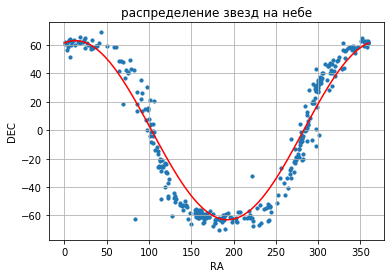

In [92]:
#Убедимся чтo звезды в плоскости галактического экватора 
x = np.linspace(0,360, 100)
y = np.cos((x-193)/180*np.pi)*-(90-27)
plt.scatter(data['RAJ2000'], data['DEJ2000'],s=10)
plt.plot(x,y,color='red')
plt.title("распределение звезд на небе")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.grid()
plt.show()

In [93]:
def sin (deg):
    '''Принимает аргумент в градусах'''
    return np.sin(deg/180*np.pi)
def cos (deg):
    '''Принимает аргумент в градусах'''
    return np.cos(deg/180*np.pi)

def eqV_to_galV(ra,dec, vra, vdec) -> [float, float]:
    '''Переводит экваториальные скорости в гелиоцентрическую галактическую систмему координат'''
    A = 192.85948
    D = 27.12825

    s1 = np.sin(dec/180*np.pi)*np.sin(D/180*np.pi) + np.cos(dec/180*np.pi)*np.cos(D/180*np.pi)*np.cos((ra-A)/180*np.pi)
    s2 = np.sqrt(1-s1**2)
    sx = np.cos(D/180*np.pi)*np.sin((ra-A)/180*np.pi)/s2
    cx = (np.sin(D/180*np.pi)*np.cos(dec/180*np.pi)-np.cos(D/180*np.pi)*np.sin(dec/180*np.pi)*np.cos((ra-A)/180*np.pi))/s2
    vl =  vra*cx + vdec*sx
    vb = -vra*sx + vdec *cx
    return (vl, vb)
    
def c_to_gal_c (ra,dec):
    '''Переводит координаты из экваториальной СК в гелиоцентрическую галактическую СК'''
    c = SkyCoord(ra, dec, unit="deg") 
    c = c.transform_to('galactic')
    return list(map(float, c.to_string ().split(' ')))

Перейдем в галактическую СК и убедимся, что звезды сконцентрированны вблизи экватора (b=0)

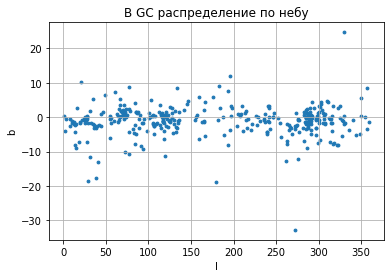

In [94]:
#Перевод в галактическю СК 
galcoord = list(map(c_to_gal_c, data['RAJ2000'],data['DEJ2000']))
galv = list(map(eqV_to_galV,data['RAJ2000'],data['DEJ2000'],data['pmRA'],data['pmDE']))
galverr = list(map(eqV_to_galV,data['RAJ2000'],data['DEJ2000'],data['e_pmRA'],data['e_pmDE']))

#Рисование графика 
plt.scatter([c[0] for c in galcoord], [c[1] for c in galcoord],s=8)
plt.title("В GC распределение по небу")
plt.xlabel("l")
plt.ylabel("b")
plt.grid()
plt.show()

#переход в ГК прошел удачно, звезды выстроились вдоль экватора 

### Двойные волны 

построим распределение скоростей по галактической долготе, зелеными кррестами обозначены погрешности определения скорости

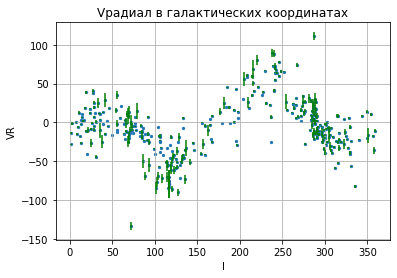

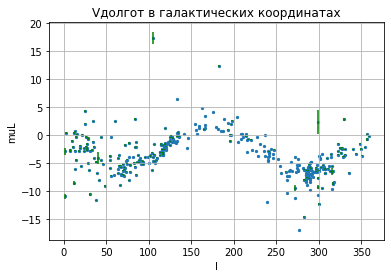

In [95]:
x = [c[0] for c in galcoord]
y = data['RV'] 
yerr = data['e_RV']
plt.scatter(x,y, s=5)
plt.errorbar(x,y,yerr=yerr, fmt='none',c='green')
plt.title("Vрадиал в галактических координатах")
plt.xlabel("l")
plt.ylabel("VR")
plt.grid()
plt.show()

x = [c[0] for c in galcoord]
y = [c[0] for c in galv]
yerr = [c[0] for c in galverr] #грубая оценка погрешностей
plt.scatter(x, y,s=5)
plt.errorbar(x,y,yerr=yerr, fmt='none',c='green')
plt.title("Vдолгот в галактических координатах")
plt.xlabel("l")
plt.ylabel("muL")
plt.grid()
plt.show()

#наблюдается волны  скоростях в гелиоцентрических ГК

Parameters(U0=8.885958100664018, V0=5, W0=7.880342495092839, siqu=13.97015499333953, siqv=20.67811065839736, siqw=14.810854807430355, w0=29.65508197079412, w1=-4.019870559808494, w2=0.6299960341192739)


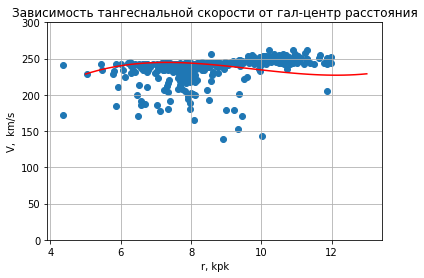

Parameters(U0=8.885958100664018, V0=5, W0=7.880342495092839, siqu=13.97015499333953, siqv=20.67811065839736, siqw=14.810854807430355, w0=29.65508197079412, w1=-4.019870559808494, w2=0.6299960341192739)


In [144]:
def transform_sfer_to_decart(ra, dec, r)->[float, float, float]: 
    """
    Углы в градусах, конвектирует из сферических коодинат в декартовы
    ra dec r -> x,y,z
    """
    x = r*cos(dec)*cos(ra)
    y = r*cos(dec)*sin(ra)
    z = r*sin(dec)
    return x,y,z
    
def transform_sfer_to_decart_array (ra, dec, r)->[np.array, np.array, np.array]:
    """
    Углы в градусах, конвектирует из сферических коодинат в декартовы
    принимает массив координат, возращает три массива (соотвесвтие по номеру индекса)
    ra dec r -> x,y,z
    """
    dim = len(ra)
    x = np.zeros(dim)
    y = np.zeros(dim)
    z = np.zeros(dim)
    for i in range(dim):
        x[i],y[i],z[i] = transform_sfer_to_decart(ra[i],dec[i],r[i])
    return x,y,z
        

#Галактические координаты 
lra =  np.array([i[0] for i in galcoord])
bdec = np.array([i[1] for i in galcoord])
r = np.array([i for i in data['D_Laz']])

#Гал скорости
vr = np.array(data['RV'])
vl =  np.array([i[0]*r*4.7 for i,r in zip(galv, data['D_Laz'])])
vb = np.array([i[1]*r*4.7 for i,r in zip(galv, data['D_Laz'])])
#Ошибки гал скорости
vr_err = np.array(data['e_RV'])
vl_err = np.array([i[0]*r*4.7 for i,r in zip(galverr, data['D_Laz'])])
vb_err =  np.array([i[1]*r*4.7 for i,r in zip(galverr, data['D_Laz'])])

#перевод в прямоугольную СК координат и скоростей
x,y,z= transform_sfer_to_decart_array(lra, bdec, data['D_Laz'])
#делаение на 30 для удобства отображения 
vx,vy,vz = transform_sfer_to_decart_array(vl/30, vb/30, np.array(data['RV'])/30) 
x1=x-R0

p  = Parameters(U0=8.885958100664018, V0=5, W0=7.880342495092839, siqu=13.97015499333953, siqv=20.67811065839736, siqw=14.810854807430355, w0=29.65508197079412, w1=-4.019870559808494, w2=0.6299960341192739)
#p =step.param
#p = {'U0': 8.90027916931819, 'V0': 13.491033033681257, 'W0': 7.698010810101314, 'siqu': 17.291873067012325, 'siqv': 22.042285211307913, \
#'siqw': 17.2787970521147, 'w0': 27.11099651831307, 'w1': -3.046729619321604, 'w2': -0.3094668025848607}
vy1=30*vy-p.w0*R0
#p =step.param
print(p)
#{'U0': 8.90027916931819, 'V0': 13.491033033681257, 'W0': 7.698010810101314, 'siqu': 17.291873067012325, 'siqv': \
#    22.042285211307913, 'siqw': 17.2787970521147, 'w0': 27.11099651831307, 'w1': -3.046729619321604, 'w2': -0.3094668025848607}
angle = np.arctan2(y,x1)
v_tan = -np.sin(angle)*vx*30+vy1*np.cos(angle)
#print ([[ai,vi] for vi, ai in zip(v_tan, angle)])
%matplotlib inline
plt.scatter(np.sqrt(x1*x1+y*y+z*z), v_tan)
plt.title("Зависимость тангеснальной скорости от гал-центр расстояния")
xlinspace = np.linspace(5,13)
plt.plot(xlinspace,xlinspace*(p.w0+p.w1*(xlinspace-R0)+(p.w2)/2*(xlinspace-R0)**2), c='red')
#plt.plot(xlinspace,xlinspace*(27+-3*(xlinspace-R0)+0.1/2*(xlinspace-R0)**2), c='red')
plt.ylim(0,300)
plt.grid()
plt.xlabel('r, kpk')
plt.ylabel('V,  km/s')
plt.show()
'''
gal_r = np.zeros(len(r))
gal_r = r_centriod_galcenter(r,lra,bdec)
sun_v=np.array([0,p['w0']*R0,0])
gal_v = np.sqrt((vx-sun_v[0]/30)**2-0.4*(vy-sun_v[1]/30)**2)
plt.scatter(gal_r, gal_v*30)
xxx = np.linspace(5,20)
plt.plot(xxx,xxx*(28+-4.6*(xxx-R0)-0.8/2*(xxx-R0)**2))
plt.scatter(1,1)
plt.ylim(0,350)
plt.show()
'''
plt.plot('')
print(p)

#при R=7.5
#Parameters(U0=8.885958100664018, V0=5.2666965679750275, W0=7.880342495092839, siqu=13.97015499333953, siqv=20.67811065839736, siqw=14.810854807430355, w0=29.65508197079412, w1=-4.019870559808494, w2=0.4299960341192739)

#8.2
#Parameters(U0=8.819449132565623, V0=5.659997454207415, W0=7.868252900337845, siqu=14.067966356104286, siqv=20.58791862929684, siqw=14.767007184777144, w0=29.297960679394972, w1=-3.6058647719564214, w2=0.27878337164040357)

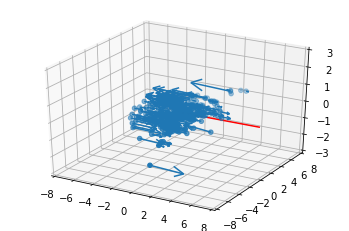

In [97]:

'''
            Начнем отрисовку 3D графика, где точка положение звезды в галактие,
         a стрелкой указана направления вектора скорости. Точка  отсчета - Солнце
         Оси в kpk, красная линия указывает на (8.2,0,0)  то есть положения центра галактики
'''

#массив с размерами для каждой точек
s = [10]*len(x)

#эта команда для рисование не в отдельном окне,нужно для среды jupytera 
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x,y,z,s)
ax.plot([8,0],[0,0],[0,0] ,c='red')
ax.quiver(x,y,z,vx,vy,vz)
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_zlim(-3,3)
plt.show()
#видно что вращение идет как бы вокруг Солнца. Вычтем вектор Vsun

(-3, 3)

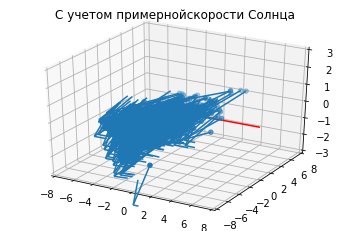

In [98]:
#вычстим из скорости Vsum=(0,240,0)
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title("С учетом примернойскорости Солнца")
ax.scatter(x,y,z,s)
ax.plot([8,0],[0,0],[0,0] ,c='red')
ax.quiver(x,y,z,vx,vy-240/30,vz)
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
ax.set_zlim(-3,3)
#plt.show()

Графики выше демонстрируют, что звезды сконцентриованы в плоскости галактики.
И так как вектора скорости совпадают с ождаемыми направлениям, можно сделать вывод, что переход в галактические координаты сделан верно. Далее приступим к подготовке к вычеслению функции правдоподобия. 

### 4. Поле пространственных скоростей и формулы Ботлингера

Напишем ряд вспомогательный функций для расчета пикулярной скорости

In [284]:
31*8.2

254.2

In [99]:
#эта функция не понадобилась 
def Vcircl_fun (r, l, b, w, w0,r0=R0) -> np.array:
    """r in kps, r,b in deg"""
    Vcirсl = np.array([r0*(w-w0)*sin(l),
                       (r0*cos(l)-r*cos(b))*(w-w0)-w0*r*cos(b),
                       -r0*(w-w0)*sin(l)*sin(b)])
    return Vcirсl

def GT_fun(r, l, b,r0=R0) -> np.array:
    """r in kps, l,b in deg
        матрица поворота, переводящая вектор скорости Солнца
    из локальной прямоугольной галактической системы координат в
    систему координат, связанную с направлением на звезду (т.е.
    задающая вклад скорости Солнца относительно выборки в
    наблюдаемую пространственную скорость звезды)
    (см методичку)
    """
    return np.array([
        [cos(l)*cos(b),   sin(l)*cos(b), sin(b)],
        [-sin(l),         cos(l),      0],
        [-cos(l)*sin(b), -sin(l)*cos(b), cos(b)]
    ])
    return Vcirсl

def angle_sight_galcentr(r,l,b,R0=R0):
    """
        Вспомогательный угол L между лучом зрения и большой
    осью эллипсоида скоростей, определяющий ориентацию эллипсоида
    относительно луча зрения, вычисляется по очевидной формуле
    (см методичку)
    """
    tgL=R0*sin(l)/(R0*cos(l)-r*cos(b))
    return np.arctan(tgL)*180/np.pi
    
def Gs_fun(r, l, b) -> np.array:
    """
    r in kps, l,b in deg
        преобразование поворота от главных осей
    эллипсоида к локальным осям, осуществляется  с помощью
    матрицы Gs : e_loc = Gs*e_s
    (См методичку)
    """
    #расчет вспомогательного угла
    L = angle_sight_galcentr(r,l,b)
    return np.array([
        [cos(b)*cos(L),  cos(b)*sin(L),sin(b)],
        [-sin(L),        cos(L),           0],
        [-sin(b)*cos(l),-sin(b)*sin(L),cos(b)]
    ])

def r_centriod_galcenter(r,l,b, R0=R0):
    """ 
        Расстояние R
        центроида S от оси Галактики (см методичку)
    """
    return np.sqrt(R0**2+(r*cos(b))**2-2*r*R0*cos(b)*cos(l))


Далее введем дополнительные структуры данных для удобства работы:

In [100]:
@dataclass 
class Parameters():
    """
    Класс для записи свободных параметров в функции правдоподобия
    """
    U0: float #скорость солнца 
    V0: float
    W0: float
    siqu: float #эллипсодиды скоростей
    siqv: float
    siqw: float
    w0: float
    w1: float
    w2: float #вторая производная локальной угловой скорости 

@dataclass
class Stars ():
    """Хранения параметров населения звезд, все данные в массивах"""
    #Сферические координаты  в гелиоцентрической галактической СК
    r: np.array #Гелиоцентрическое расстояние kpk
    l: np.array #Долгота deg
    b: np.array #Широта deg
        
    #Cферические скорости  собсвенного движения в гелиоцентрической галактической СК
    vr: np.array #радиальная
    vl: np.array #долготная
    vb: np.array #широтная
    
    #Ошибки  скоростей  собсвенного движения в sunГалСК
    vr_err: np.array
    vl_err: np.array
    vb_err: np.array

Для удобства работы с функцией максимального правдоподобия L, будем проводить взаимодействие  с помощью класса Likelihood

In [ ]:
class Likelihood (): 
    """
    Класс функции правдоподобия LF. При каждой итерации класс изменяет свои внутренние параметры
    метод self.LF(x) Изменяет внутренние параметры с соотвествием массива х
        и  возращает значение LF  при данных параметров.
    Ожидается следующее использование класса в функции минимизатора 
    minimize(likelihood.LF), где likelihood экземляр класса
    
    """
    def __init__ (self,param: Parameters, stars: Stars):
        self.param = param #параметры  ['U0', 'V0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']
        #Список названий параметров, которые можно варьировать при минимизаци, остальные параметры считаются закрепленными
        self.current_param_key  = list(self.param.__dict__)         
        self.stars = stars #Хранит  данные о звездах,(очевидно данные не изменяются данным классом)
        
        #Вспомогательные расчеты матриц переход, ошибок и тп
        #Делает массив 3-ех мерных векторов скоростей звезд [V1, V2,... Vn] где Vi=[Vr,Vl,Vb]. Для удобства обращения 
        self.NVobs = np.array([[self.stars.vr[i],self.stars.vl[i],self.stars.vb[i]]for i,_ in enumerate(self.stars.vr)])
        #Массив из матриц поворота Gs те [Gs_1, Gs_2,... Gs_N](Gs поворот элипсоида скоростей к локальным, см методичку)
        self.Gs = np.array([Gs_fun(self.stars.r[i], self.stars.b[i], self.stars.l[i]) for i,_ in enumerate(self.stars.b)])
        #Массив из матриц  ошибок скоростей [Lerr_1, Lerr_2, ... Lerr_N]. (см методичку)
        self.Lerr = np.array([[
                        [self.stars.vr_err[i]**2 ,0,0],
                        [0,self.stars.vl_err[i]**2,0],
                        [0,0,self.stars.vb_err[i]**2]]\
                            for i,_ in enumerate(self.stars.vr_err)])
        #массив растояний от звезды до центра галактики
        self.R = np.array([r_centriod_galcenter(self.stars.r[i], self.stars.l[i], self.stars.b[i]) for i,_ in enumerate(self.stars.r)])
        ##Массив из матриц перехода GT те [GT_1, GT_2,... GT_N] (GT поворот, для учета вклада  Vsun на направление на звездy, см методичку)
        self.GT = np.array([GT_fun(self.stars.r[i], self.stars.l[i], self.stars.b[i]) for i,_ in enumerate(self.stars.r)])
        #текущие значенеи функции правдоподобия
        self.lf = float('inf')
        
    def get_x0 (self):
        '''возрашает начальный вектор значения для минимизатора, состоит из НЕ закрепленных  значений '''
        x0 = list()
        for key in self.current_param_key:
            x0.append(self.param.__dict__[key])
        return np.array(x0)
    def set_x0_param(self, var_dict: dict):
        '''для удобвста записывает параметры в виде словаре, чтобы потом вызвать x0, 
        может поменть значение фиксированных переменных, но оставит их фиксированными
        '''
        for key, val in var_dict.items():
            self.edit_param(key, val)
        return self.get_x0()
    
    def edit_param (self, key, value):
        """ Изменяет параметры по ключу и значению"""
        if key in list(param.__dict__):
            self.param.__dict__[key] = value
        else: print(f"{key} not in { param.__dict__.keys()}") 
    
    def fix_var(self, var_dict: dict):
        """фиксирует заданые название значение, предыдущие закрпленные параметры стираются
        то есть по новой идет фиксация, без учета пердыдущий
        """
        keys = list(self.param.__dict__) #список всех доступных наименований параметров
        for key, value in var_dict.items(): 
            keys.remove(key) #убираю фикс парам из списка доступных для изменения названий параметров 
            self.edit_param(key, value)
        self.current_param_key = keys 
        
    def edit_param_from_array(self, x :np.array):
        """ Изменяет параметры по массиву значений
         предпологается, что порядок в массиве соотвествует переменным в пордяке self.current_param_key
         При коррекной работе с классом это гарантированно будет выполнено
        """
        if (len(x) != len (self.current_param_key)):
            raise Exception(f"длина x не свопадает с количеством незафиксированных параметров x: {x},\
                self: {self.current_param_key}")
        for key, xx in zip(self.current_param_key, x):
            self.edit_param(key, xx)
 
    def LF(self, x: np.array):
        """Возращает значени функции максимального правдоподобия при параметрах X и
        сохранает это значение в self.lf
        """
        self.edit_param_from_array(x) #изменение внутренних параметрами согласно x 
        lf = 0
        for i,_ in enumerate(self.stars.r): #для каждой звезды считается значение функции и затем складывается 
            global R0
            R0 = R0 #расстояние до центра галактики kpс
            # индекс i в 'naei' имени переменной означает что подсчитанно только для i-ой звезды, и не массив [name1,name2,... nameN]
            Lsi= np.array([ #матрица дисперсий (неизвестные параметры)
                    [self.param.siqu**2,0,0],
                    [0,self.param.siqv**2,0],
                    [0,0,self.param.siqw**2]
            ])
            
            #модифицированная матрица ковариациий
            #Lobs=Lloc + Lerr
            Lobsi = self.Gs[i].dot(Lsi.dot(self.Gs[i].T)) + self.Lerr[i]
        
            #Разложение в ряд угловой скорости
            w_w0 = self.param.w1*(self.R[i]-R0) +0.5*self.param.w2*(self.R[i]-R0)**2
            
            #Расчет пикулярной скорости 
            #Вклад кругового вращения 
            roti = np.array([
                    R0*w_w0*sin(self.stars.l[i])*cos(self.stars.b[i]),\
                    (R0*cos(self.stars.l[i])-self.stars.r[i]*cos(self.stars.b[i]))*w_w0 - self.param.w0*self.stars.r[i]*cos(self.stars.b[i]),\
                    -R0*w_w0*sin(self.stars.l[i])*sin(self.stars.b[i])\
                    ])
            #Проекция скорости солнца на звезду
            Vsuni = self.GT[i].dot(np.array([self.param.U0,self.param.V0,self.param.W0]))
            #Пикулярная скорость
            dVi = self.NVobs[i] - roti + Vsuni 
            
            #расчет логорифма функции распределения (в трехмерии для нормального трёхосного распределения, см методичку)
            lf+= 0.75*np.log(2*np.pi) + 0.5*np.log(np.abs(np.linalg.det(Lobsi))) +0.5*dVi.dot(np.linalg.inv(Lobsi).dot(dVi))
        #print (lf)
        self.lf = lf
        return lf


### Принцип максимального правдоподобия
Теперь может провести рассчет параметров, которые минимизируют Фукнцию правдоподобия. 
Зададим исходные данные

In [141]:
#начальные параметры 
param = Parameters(U0=10,V0=12,W0=7,siqu=14,siqv=9,siqw=7,w0=27.5,w1=-4.4,w2=0.8)
#данные о звездах были посчитанны выше в коде
stars_sun = Stars(
    r = r ,
    l = lra,
    b = bdec,
    vr = vr,
    vl = vl, 
    vb = vb,
    vr_err = vr_err,
    vl_err = vl_err,
    vb_err = vb_err,
    
)
step = Likelihood(param,stars_sun)

#['U0', 'V0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']
print("изначально все пармаетры свободные: ", step.current_param_key)
print ("   *****   зафиксируем U0")
#step.fix_var({'U0': 10,"V0":12,"W0":7,"siqu":14,"siqv":9,"siqw":7,'w0':27.5,"w1":-4.4})
print("после фиксации из списка пропала закрпеленная UO: ", step.current_param_key)
print ("   *****   освободим все параметры, передав пустой словарь")
step.fix_var({'V0': 15})
print("Проверим что все свободны: ", step.current_param_key)

изначально все пармаетры свободные:  ['U0', 'V0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']
   *****   зафиксируем U0
после фиксации из списка пропала закрпеленная UO:  ['U0', 'V0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']
   *****   освободим все параметры, передав пустой словарь
Проверим что все свободны:  ['U0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']


In [37]:
#тесты на тестовом эллипсиоде 

#начальные параметры 
param = Parameters(U0=7,V0=15,W0=17,siqu=15,siqv=22,siqw=0,w0=0,w1=0,w2=0)
#данные о звездах были посчитанны выше в коде
qqq = np.random.normal(0,40,size=1000)
qqq = np.zeros(1000)+90
stars_sun = Stars(
    r = np.zeros(1000),
    l = np.zeros(1000),
    b = np.zeros(1000),
    vr = np.zeros(1000),
    vl = np.random.normal(12,20,size=1000), 
    vb = np.zeros(1000),
    vr_err = np.zeros(1000),
    vl_err = np.zeros(1000),
    vb_err = np.zeros(1000),
    
)
step = Likelihood(param,stars_sun)

#['U0', 'V0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']
print("изначально все пармаетры свободные: ", step.current_param_key)
print ("   *****   зафиксируем U0")
step.fix_var({'U0': 0})
print("после фиксации из списка пропала закрпеленная UO: ", step.current_param_key)
print ("   *****   освободим все параметры, передав пустой словарь")
step.fix_var({})
print("Проверим что все свободны: ", step.current_param_key)

изначально все пармаетры свободные:  ['U0', 'V0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']
   *****   зафиксируем U0
после фиксации из списка пропала закрпеленная UO:  ['V0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']
   *****   освободим все параметры, передав пустой словарь
Проверим что все свободны:  ['U0', 'V0', 'W0', 'siqu', 'siqv', 'siqw', 'w0', 'w1', 'w2']


In [142]:
#задачем начальные параметры. Примерные значения взял из литературы 
#http://lnfm1.sai.msu.ru/~milkyway/Study/Kinematics.pdf

#step.set_x0_param({'U0':-5, 'V0':-10, 'W0':-5, 'siqu':14, 'siqv':9, 'siqw':7, 'w0':30, 'w1':-5, 'w2':1})
#p = {'U0': 9.163876193135224, 'V0': 6.12168161832367, 'W0': 7.889521573026231, 'siqu': 13.137244849856135, 'siqv': 18.8671910525901, 'siqw': 15.229718094280127, 'w0': 30.002879358104217, 'w1': -3.789283577944868, 'w2': 0.43921467025610295}
#step.set_x0_param(p)

#запускаем минимизацию. Печатаются текущие значение LF Видно что в конце они очень медленно уменьшаются (это почти плато минимума)
res0 = minimize(step.LF, step.get_x0(), method='nelder-mead',
    options={'xtol': 1e-8, 'disp': True})

print (res0)
#прооверим значение переменных
print(step.param.__dict__)
#необходимо повторить минимизацию пока фит не будет успешным, обычно хватает два раза, с заменой НУ на результат фита 


Optimization terminated successfully.
         Current function value: 4185.629608
         Iterations: 844
         Function evaluations: 1315
 final_simplex: (array([[ 9.5021089 ,  7.67841048, 16.70611553, 20.49212212, 15.50885199,
        28.4988088 , -3.75148326,  0.69584021],
       [ 9.5021089 ,  7.67841049, 16.70611554, 20.49212213, 15.50885199,
        28.49880881, -3.75148326,  0.69584021],
       [ 9.5021089 ,  7.67841048, 16.70611553, 20.49212213, 15.50885199,
        28.49880881, -3.75148326,  0.69584021],
       [ 9.5021089 ,  7.67841048, 16.70611553, 20.49212213, 15.50885199,
        28.49880881, -3.75148326,  0.69584021],
       [ 9.5021089 ,  7.67841048, 16.70611554, 20.49212213, 15.50885199,
        28.49880881, -3.75148326,  0.69584021],
       [ 9.5021089 ,  7.67841048, 16.70611554, 20.49212212, 15.50885198,
        28.49880881, -3.75148326,  0.69584021],
       [ 9.5021089 ,  7.67841048, 16.70611553, 20.49212212, 15.50885199,
        28.49880881, -3.75148326,  0.695

Видим ошибку *Warning: Maximum number of function evaluations has been exceeded.* значит надо взять выходные значения и продолжить минимизацию:
выходные значения: 
LF = 2824.69 (менялаь с третьем знаке последние шаги) 

{'U0': -0.0052, 'V0': 6.124, 'W0': 0.0189, 'siqu': 14.855, 'siqv': 20.2996, 'siqw': 16.858, 'w0': 30.43, 'w1': -3.84, 'w2': 0.44}

In [42]:
#выходные параметры прошлой итерации
p={'U0': 8.81945261902743, 'V0': 5.660000293233926, 'W0': 7.8682133795847236, 'siqu': 14.067979660654597, 'siqv': 20.587911424557298, 'siqw': 14.767026686056305, 'w0': 29.297959619872955, 'w1': -3.605865662873187, 'w2': 0.27878653552628196}
#p = {'U0': -0.00526111619060203, 'V0': 6.1244766663338766, 'W0': 0.018904229247651935, 'siqu': 14.855174096346072, 'siqv': 20.299665283123247, 'siqw': 16.85818319298103, 'w0': 30.43946215733088, 'w1': -3.8442826162742856, 'w2': 0.4422801186839095}
step.set_x0_param(p)

res1 = minimize(step.LF, step.get_x0(), method='nelder-mead',
    options={'xtol': 1e-8, 'disp': True})

#print (res1)
#прооверим значение переменных
print(step.param.__dict__)

Optimization terminated successfully.
         Current function value: 4262.700752
         Iterations: 1136
         Function evaluations: 1723
{'U0': 8.90027916931819, 'V0': 13.491033033681257, 'W0': 7.698010810101314, 'siqu': 17.291873067012325, 'siqv': 22.042285211307913, 'siqw': 17.2787970521147, 'w0': 27.11099651831307, 'w1': -3.046729619321604, 'w2': -0.3094668025848607}


In [48]:
#И накоец третья итерация 
#p = {'U0': 9.064078727574213, 'V0': 6.1265855091023695, 'W0': 7.96679360763638, 'siqu': 13.140209411260306, 'siqv': 18.853887575941684, 'siqw': 15.237878583891352, 'w0': 30.006398581049055, 'w1': -3.7872282801005532, 'w2': 0.4387475065763782}
#step.set_x0_param(p)

res2 = minimize(step.LF, step.get_x0(), method='nelder-mead',
    options={'xtol': 1e-8, 'disp': True})
#на этот раз удалось дойти до минимума 

print (res2)
#прооверим значение переменных
print(step.param.__dict__)


Optimization terminated successfully.
         Current function value: 2755.277672
         Iterations: 523
         Function evaluations: 849
 final_simplex: (array([[ 9.05944589,  6.12070608,  7.96515454, 13.13508281, 18.86869029,
        15.23230465, 30.00496864, -3.78900472,  0.43909544],
       [ 9.05944589,  6.12070608,  7.96515454, 13.13508281, 18.86869029,
        15.23230465, 30.00496864, -3.78900472,  0.43909544],
       [ 9.05944589,  6.12070608,  7.96515454, 13.13508281, 18.86869029,
        15.23230465, 30.00496864, -3.78900472,  0.43909544],
       [ 9.05944588,  6.12070608,  7.96515454, 13.13508281, 18.86869029,
        15.23230465, 30.00496864, -3.78900472,  0.43909544],
       [ 9.05944589,  6.12070608,  7.96515454, 13.13508281, 18.86869029,
        15.23230465, 30.00496864, -3.78900472,  0.43909544],
       [ 9.05944589,  6.12070608,  7.96515454, 13.13508281, 18.86869029,
        15.23230465, 30.00496864, -3.78900472,  0.43909544],
       [ 9.05944589,  6.12070608,  7

Спустя три итерации мы получилис конечные значения параметров 
{'U0': 9.059445881840166, 'V0': 6.120706082929178, 'W0': 7.965154542683982, 'siqu': 13.135082805157484, 'siqv': 18.868690292681343, 'siqw': 15.232304650762227, 'w0': 30.004968633877056, 'w1': -3.7890047212893494, 'w2': 0.43909544253405075}

### Подсчет ошибок

Для подсчета ошибок варьируем по очереди параметр, увеличив его на нексолько процентов dx. Заметим, что от dx ОЧЕНЬ сильно влияет на величину ошибок. Я остановился на добавке 10% (т.е. delta_ratio=0.1) 

In [53]:
#Функция для подсчета ошибок 
def solve_error_by_key(step: Likelihood, key: str, delta_ratio):
    '''delta_ratio во сколько раз надо изменить начальное условие'''
    x0 = step.param.__dict__ #запоминю начальные усдловия 
    lf0 = step.lf
    #print (:(x0[key]*(1+delta_ratio)))
    step.fix_var({key: x0[key]*(1+delta_ratio)})
    #в процессе минимизации step будет изменяться и запомнит конечную итерцацию
    res = minimize(step.LF, step.get_x0(), method='nelder-mead',
        options={'xtol': 1e-5, 'disp': True})
    #print(step.param.__dict__)
    lf = step.lf
    
    step.set_x0_param(x0) #возращаю класс в исходное состояние 
    step.lf = lf0
    
    return np.abs(x0[key]*(1+delta_ratio)/np.sqrt(np.abs(2*(lf0-lf))))

In [62]:
#delta_ratio = 0.1
err = {}
for key in step.param.__dict__.keys():
    err[key]=solve_error_by_key(step, key, delta_ratio=0.1)
#print(err)
print ("Итоговые данные:")
for key, val in err.items():
    #print (f"{key:>5}: {step.param.__dict__[key] : >10.2} +- {err[key]: <10.2}  dx/x: {err[key]/step.param.__dict__[key]: <10.2}")
    print (f"|{key:>5}|{step.param.__dict__[key] : >10.2} +- {err[key]: <10.2}| {err[key]/step.param.__dict__[key]: <10.2}|")


Optimization terminated successfully.
         Current function value: 2755.453640
         Iterations: 698
         Function evaluations: 1024
Optimization terminated successfully.
         Current function value: 2755.592235
         Iterations: 289
         Function evaluations: 475
Optimization terminated successfully.
         Current function value: 2755.693904
         Iterations: 251
         Function evaluations: 421
Optimization terminated successfully.
         Current function value: 2757.388704
         Iterations: 452
         Function evaluations: 683
Optimization terminated successfully.
         Current function value: 2757.340584
         Iterations: 381
         Function evaluations: 589
Optimization terminated successfully.
         Current function value: 2757.181507
         Iterations: 486
         Function evaluations: 745
Optimization terminated successfully.
         Current function value: 2777.998857
         Iterations: 488
         Function evaluations: 74

In [105]:
#delta_ratio = 0.2
err = {}
for key in step.param.__dict__.keys():
    err[key]=solve_error_by_key(step, key, delta_ratio=0.2)
#print(err)
print ("Итоговые данные:")
for key, val in err.items():
    #print (f"{key:>5}: {step.param.__dict__[key] : >10.2} +- {err[key]: <10.2}  dx/x: {err[key]/step.param.__dict__[key]: <10.2}")
    print (f"|{key:>5}|{step.param.__dict__[key] : >10.2} +- {err[key]: <10.2}| {err[key]/step.param.__dict__[key]: <10.2}|")
#Ошибки сильно подскочили у некотрых параметров 

Optimization terminated successfully.
         Current function value: 4679.143436
         Iterations: 292
         Function evaluations: 479
Optimization terminated successfully.
         Current function value: 4678.488088
         Iterations: 416
         Function evaluations: 653
Optimization terminated successfully.
         Current function value: 4679.370303
         Iterations: 414
         Function evaluations: 628
Optimization terminated successfully.
         Current function value: 4689.214591
         Iterations: 445
         Function evaluations: 697
Optimization terminated successfully.
         Current function value: 4688.943623
         Iterations: 470
         Function evaluations: 731
Optimization terminated successfully.
         Current function value: 4687.771341
         Iterations: 473
         Function evaluations: 724
Optimization terminated successfully.
         Current function value: 4779.404856
         Iterations: 674
         Function evaluations: 100

### Итоговые результаты для snr>10

|name|result|dx/x|
|-|-|-|
|   U0|       9.0 +- 2.8       | 0.31      |
|   V0|       5.2 +- 2.0       | 0.38      |
|   W0|       7.5 +- 2.6       | 0.34      |
| siqu|   1.4e+01 +- 4.9       | 0.36      |
| siqv|   2.2e+01 +- 7.0       | 0.32      |
| siqw|   1.6e+01 +- 5.6       | 0.36      |
|   w0|   3.1e+01 +- 6.6       | 0.21      |
|   w1|      -4.6 +- 0.74      | -0.16     |
|   w2|      0.61 +- 0.076     | 0.12      |


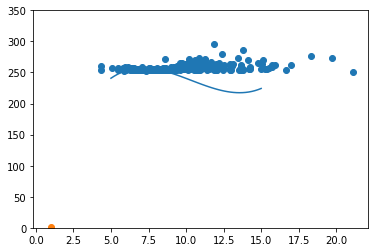

In [281]:
gal_r = np.zeros(len(r))
gal_r = r_centriod_galcenter(r,lra,bdec)
sun_v=np.array([0,31*8.2,0])
gal_v = np.sqrt((vx-sun_v[0]/30)**2+(vy-sun_v[1]/30)**2+(vz-sun_v[2]/30)**2)
plt.scatter(gal_r, gal_v*30)
x = np.linspace(5,15)
plt.plot(x,x*(31+-4.4*(x-8.2)+0.6/2*(x-8.2)**2))
plt.scatter(1,1)
plt.ylim(0,350)
plt.show()


In [279]:
class Curve_v(Likelihood):
    def __init__(self, likelihood: Likelihood):
        Likelihood.__init__ (self,likelihood.param, likelihood.stars)
        
    def gal_centr_v(self):
        R0=8.2
        gal_v_c = np.zeros(len(self.stars.r))
        for i,_ in enumerate(self.stars.r):
            w_w0 = 0
            #print (w_w0)
            roti=np.array([0,250,0])
            '''roti = np.array([
                        R0*w_w0*sin(self.stars.l[i])*cos(self.stars.b[i]),\
                        (R0*cos(self.stars.l[i])-self.stars.r[i]*cos(self.stars.b[i]))*w_w0 - self.param.w0*self.stars.r[i]*cos(self.stars.b[i]),\
                        -R0*w_w0*sin(self.stars.l[i])*sin(self.stars.b[i])\
                        ])'''
            #Проекция скорости солнца на звезду
            Vsuni = self.GT[i].dot(np.array([self.param.U0,self.param.V0,self.param.W0]))
            #Пикулярная скорость
            dVi = self.NVobs[i] + Vsuni -roti
            #print (Vsuni, dVi,self.NVobs[i][1])
            gal_v_c[i]= np.sqrt(np.sum(dVi*dVi))
        return gal_v_c
